## Feature Extraction: Under the hood

In [1]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import librosa.display

## Orginial Signal

In [2]:
sample_rate, signal = scipy.io.wavfile.read('../../../Source/Clean_train_clips/Shuffle/1/1.wav')  


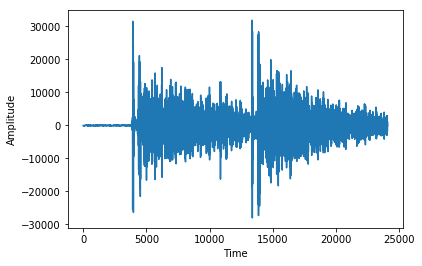

In [3]:
plt.plot(signal)
plt.xlabel('Time')
plt.ylabel('Amplitude');

## Pre-emphasis filter

In [4]:
pre_emphasis = 0.97 # Typically 0.95 or 0.97 for Automatic Speech Recognition (ASR)

In [5]:
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

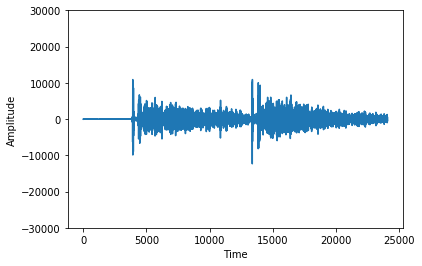

In [6]:
plt.plot(emphasized_signal)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.ylim(-30000, 30000);

## Framing

In [7]:
frame_size = 0.025 # 25 msec (Typically 20-40 msec for ASR)
frame_stride = 0.010 # 10 msec with 15 msec overlap (Typically 50% overlap)


In [52]:
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length #????


z = np.zeros((pad_signal_length - signal_length)) 
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

#plt.subplot(211)
#plt.plot(pad_signal)
#
#plt.subplot(212)
#plt.plot(emphasized_signal)

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T


frames = pad_signal[indices.astype(np.int32, copy=False)]

In [53]:
frames.shape

(53, 1102)

In [54]:
pd.DataFrame(frames).head()

,0,1,2,3,4,5,6,7,8,9,...,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101
0,-16.00,5.52,-1.30,-0.33,-2.33,4.61,-9.24,7.49,-6.27,-1.45,...,17.89,0.37,9.31,-3.48,11.34,-5.39,-4.63,17.16,-6.39,19.34
1,2.87,1.93,1.96,-3.01,3.87,6.96,5.14,14.26,7.65,27.83,...,8.04,-1.69,4.28,-2.57,-3.63,-7.72,18.07,-9.36,-1.63,22.34
2,0.52,-1.45,-0.48,8.52,-17.21,11.28,-7.36,-0.57,3.43,-0.45,...,4.38,5.56,-3.23,10.71,-14.93,-0.35,5.68,-1.11,6.89,-9.87
3,-13.44,-4.89,0.93,-15.07,-11.55,-5.91,-21.09,0.28,-14.69,6.89,...,-3.86,10.08,1.44,-0.47,2.56,-4.32,9.59,-1.08,2.92,6.04
4,-2.60,0.25,33.19,-17.88,14.49,1.85,2.82,-14.18,-6.69,6.04,...,-12.34,1.36,-0.52,-7.46,10.39,7.78,-2.92,-11.95,8.75,-0.92


## Apply (Hamming) window function to each frame

In [55]:
frames *= np.hamming(frame_length)

In [57]:
pd.DataFrame(frames).head()

,0,1,2,3,4,5,6,7,8,9,...,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101
0,-1.2800,0.441641,-0.104039,-0.026422,-0.186679,0.369663,-0.741691,0.601949,-0.504605,-0.116880,...,1.442052,0.029777,0.748217,-0.279338,0.909323,-0.431846,-0.370712,1.373314,-0.511248,1.5472
1,0.2296,0.154414,0.156859,-0.241003,0.310064,0.558103,0.412586,1.146033,0.615667,2.243282,...,0.648077,-0.136010,0.343971,-0.206293,-0.291080,-0.618525,1.446818,-0.749080,-0.130412,1.7872
2,0.0416,-0.116011,-0.038414,0.682174,-1.378863,0.904512,-0.590784,-0.045809,0.276044,-0.036273,...,0.353057,0.447465,-0.259585,0.859688,-1.197196,-0.028042,0.454783,-0.088833,0.551252,-0.7896
3,-1.0752,-0.391237,0.074428,-1.206616,-0.925384,-0.473907,-1.692887,0.022503,-1.182241,0.555379,...,-0.311141,0.811231,0.115728,-0.037727,0.205279,-0.346118,0.767846,-0.086432,0.233622,0.4832
4,-0.2080,0.020002,2.656194,-1.431605,1.160937,0.148346,0.226360,-1.139604,-0.538407,0.486864,...,-0.994685,0.109452,-0.041791,-0.598811,0.833146,0.623332,-0.233797,-0.956358,0.700066,-0.0736


## Fourier Transform and Power Spectrum

In [58]:
NFFT = 512 # Typically 256 or 512

In [59]:
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

In [60]:
mag_frames.shape

(53, 257)

In [61]:
pow_frames.shape

(53, 257)

## Filter Banks

In [ ]:
nfilt = 40

In [ ]:
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate) # floor rounds to the nearest int

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

In [ ]:
filter_banks.shape

In [ ]:
np.mean(filter_banks.T, axis=1)

## Mel-frequency Cepstral Coefficients (MFCCs)

In [ ]:
num_ceps = 12

In [ ]:
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

In [ ]:
mfcc.shape

## Mean Normalization

In [ ]:
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

In [ ]:
# filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

In [ ]:
mfcc.shape

## Feature Extraction with audio data using Mel-scaled Filterbanks

In [ ]:
path_1 = '../../../Source/Clean_train_clips/Shuffle/1/1.wav'
path_2 = '../../../Source/Clean_train_clips/Ball_change/1/3.wav'
pre_emphasis = 0.97 # Typically 0.95 or 0.97 for Automatic Speech Recognition (ASR)
frame_size = 0.025 # 25 msec (Typically 20-40 msec for ASR)
frame_stride = 0.010 # 10 msec with 15 msec overlap (Typically 50% overlap)
NFFT = 512 # Typically 256 or 512
nfilt = 40

In [ ]:
def get_filterbanks(path):
    sample_rate, signal = scipy.io.wavfile.read(path)
    
    input_length = 22050
    if len(signal) > input_length:
        signal = signal[:input_length]
    else:
        signal = np.pad(signal, (0, max(0, input_length - len(signal))), "constant")

    # Pre-emphasis filter
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    
    # Framing
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame
    
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
    
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    # Apply Hamming window function to each frame
    frames *= np.hamming(frame_length)
    
    # Fourier Transform and Power Spectrum
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    
    # Mel-scaled Filterbanks
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate) # floor rounds to the nearest int
    
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right
    
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    
    # Mean Normalization
    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
    #return filter_banks
    
    return np.mean(filter_banks, axis=1)

In [ ]:
(get_filterbanks(path_1)).shape

In [ ]:
(get_filterbanks(path_2)).shape

Hmm...OK, it seems like all clips must be the same length to get features of a similar shape with the mel-filterbank approach. <br/> What length (duration) do all my clips have?

In [ ]:
duration_list = []
for i in range(len(tap)):
    signal, sample_rate = librosa.load(tap.loc[i, 'Path'])
    duration_list.append(librosa.get_duration(y= signal, sr = sample_rate))
print ('Longest: ' + str(max(duration_list)))
print ('Shortest: ' + str(min(duration_list)))

There appears to be quite a range of lengths, from .20 seconds to .78 seconds. <br/> How can I edit these without losing any information? <br/> PADDING! <br/> Make all clips 1 second long, so everything gets a little padding.

In [ ]:
data, rate = librosa.load('../../../Source/Clean_train_clips/Shuffle/1/1.wav')
librosa.get_duration(sr=rate, y=data)
rate

In [ ]:
new_data = pad_audio_file('../../../Source/Clean_train_clips/Shuffle/1/1.wav')

## Let's do this thing: New features for all audio clips

In [ ]:
def build_list(step, folder, length):
    i = 1
    step_list = []
    while i <= length :
        name = step + "/" + str(folder) + "/" +str(i) + ".wav"
        step_list.append(name)
        i += 1
    return step_list

def get_label(path):
    if path.parts[-3] == 'Shuffle':
        return 1
    else:
        return 0

In [ ]:
shuffle_col, bc_col, path_col = [], [], []

In [ ]:
pathlist = Path('../../../Source/Clean_train_clips/Shuffle').glob('**/*.wav')
for path in pathlist:
    shuffle_col.append(path)
    shuffle_col.sort()

In [ ]:
pathlist = Path('../../../Source/Clean_train_clips/Ball_change').glob('**/*.wav')
for path in pathlist:
    bc_col.append(path)
    bc_col.sort()

In [ ]:
path_col = shuffle_col + bc_col

**Add file paths**

In [ ]:
tap = pd.DataFrame({'Path':path_col})


**Add labels**

In [ ]:
tap['Labels'] = [get_label(tap.loc[idx,'Path']) for idx in range(len(tap))]

**Add Features: Mel-scaled filterbanks**

In [ ]:
for i in range (48):
    tap[str(i)] = [get_filterbanks(tap.loc[idx, 'Path'])[i] for idx in range (len(tap))]

**Export data as csv**

In [ ]:
#tap.to_csv('../../../Source/Data/audio_data_normal_filterbanks.csv', index=None)

**Split into train and test sets**

In [ ]:
X = tap.drop(['Labels'], axis =1)
y = tap[['Labels']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [ ]:
#X_train.to_csv('../../../Source/Data/X_train_audio_normal_filterbanks.csv', index=None)
#y_train.to_csv('../../../Source/Data/y_train_audio_normal_filterbanks.csv', index=None)
#X_test.to_csv('../../../Source/Data/X_test_audio_normal_filterbanks.csv', index=None)
#y_test.to_csv('../../../Source/Data/y_test_audio_normal_filterbanks.csv', index=None)
#
#

---

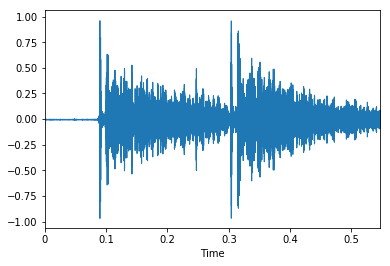

In [178]:
y, sr = librosa.load('../../../Source/Clean_train_clips/Shuffle/1/1.wav')
librosa.display.waveplot(y);

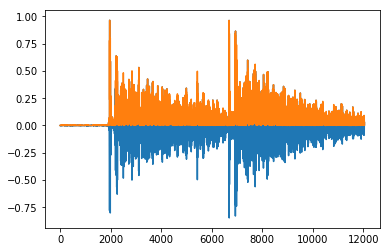

In [72]:
abs_y = np.abs(y)
#librosa.display.waveplot(abs_y);
plt.plot(y)
plt.plot(abs(y))


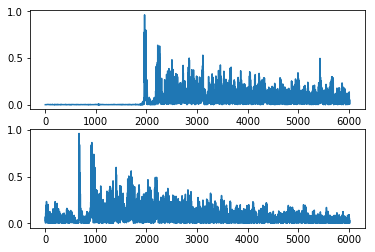

In [101]:
half_way = int(len(y)/2)
half_1 = y[:half_way]
half_2 = y[half_way:]
plt.subplot(211)
plt.plot(abs(half_1))
plt.subplot(212)
plt.plot(abs(half_2))

In [181]:
x = half_1
x = y
x_of_f = np.abs(np.fft.rfft(x, 512))
energy = (1/512)*((x_of_f)**2)

In [180]:
x_of_f.shape, energy.shape
#x_of_f

((257,), (257,))

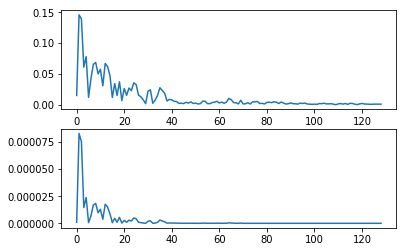

In [131]:
plt.subplot(211)
plt.plot(x_of_f)
plt.subplot(212)
plt.plot(energy)

In [401]:
y, sr = librosa.load('../../../Source/Clean_train_clips/Shuffle/1/1.wav')
rmse = librosa.feature.rmse(y, frame_length=256, hop_length=129, center=True)

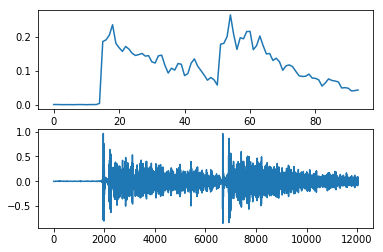

In [402]:
plt.subplot(211)
plt.plot(rmse[0]);
plt.subplot(212)
plt.plot(y)

In [404]:
len(y)/256 *2
max_1 = rmse.max()
array = rmse[0]
new_array = np.delete(array, array.argmax(), 0);
array.argmax(), new_array.argmax()
#print('Decay time between beats: ' + str(abs(array.argmax()-new_array.argmax())))

(54, 18)

---

In [230]:
y, sr = librosa.load('../../../Source/Clean_train_clips/Shuffle/1/1.wav')
y.shape[0]/64

188.109375

In [232]:
S = abs(librosa.stft(y,n_fft=256))
librosa.power_to_db(S**2).shape
S.shape


(129, 189)

1: Power spectrogram
2: Log-Power spectrogram


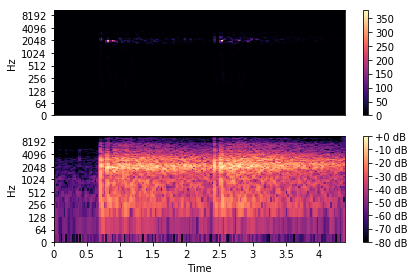

In [205]:
print('1: Power spectrogram')
print('2: Log-Power spectrogram')
plt.figure()
plt.subplot(211)
librosa.display.specshow(S**2, sr=sr, y_axis='log')
plt.colorbar()
#plt.title('Power spectrogram')

plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.power_to_db(S**2, ref=np.max),
                         sr=sr, y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
#plt.title('Log-Power spectrogram')
plt.tight_layout()

The signal frequency in the log space


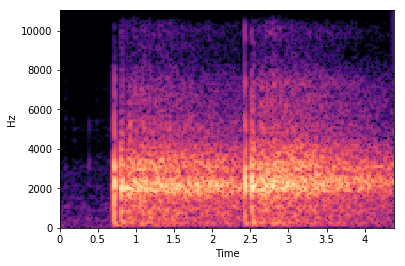

In [243]:
print('The signal frequency in the log space')
log_power = librosa.power_to_db(S**2, ref=np.max)
librosa.display.specshow(log_power , x_axis='time', y_axis='linear');


Using Constant Q transform instead of STFT


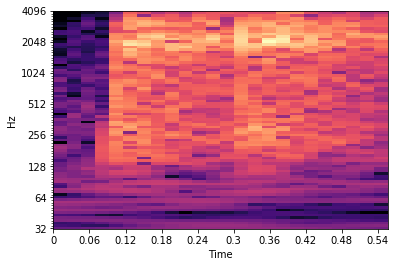

In [259]:
print ('Using Constant Q transform instead of STFT')
C = abs(librosa.cqt(y, sr))
librosa.display.specshow(librosa.power_to_db(C**2), x_axis = 'time', y_axis = 'cqt_hz');

Does tap dancing have constant notes/pitches?


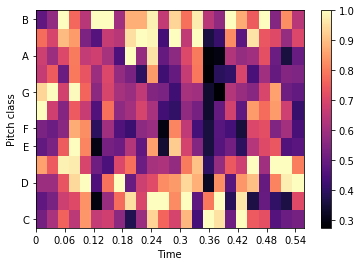

In [261]:
chroma = librosa.feature.chroma_cqt(C=C, sr=sr)
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma')
plt.colorbar();
print('Does tap dancing have constant notes/pitches?')

In [265]:
M = librosa.feature.melspectrogram(y=y, sr=sr)
MFCC = librosa.feature.mfcc(y=y, sr=sr)
M.shape, MFCC.shape

((128, 24), (20, 24))

## Onsets and beats

In [409]:
y, sr = librosa.load('../../../Source/Clean_train_clips/Ball_change/4/7.wav')

In [410]:
onset_envelope = librosa.onset.onset_strength(y=abs(y), sr=sr )

In [411]:
onsets = librosa.onset.onset_detect(onset_envelope=onset_envelope)

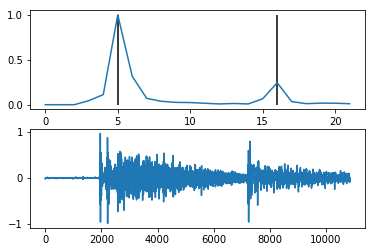

In [415]:
plt.subplot(211)
plt.plot(onset_envelope);
plt.vlines(onsets, 0, onset_envelope.max() )
plt.subplot(212)
plt.plot(y);

In [413]:
onset_envelope.shape

(22,)

In [414]:
int(np.diff(onsets))

11

In [420]:
onset_envelope[onsets]
#onsets

array([1.      , 0.244168])

In [421]:
onset_envelope

array([0.        , 0.        , 0.        , 0.04499112, 0.11238031,
       1.        , 0.31588725, 0.07011993, 0.038377  , 0.02603732,
       0.02393515, 0.01628949, 0.00846226, 0.01373003, 0.00833461,
       0.06605625, 0.244168  , 0.03477625, 0.01148324, 0.01757744,
       0.01670875, 0.0108826 ])